#Training Unsupervised B-scan classification with CNN-Based Feature Extraction

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import random
from PIL import Image
import os

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## **Load dataset**

In [57]:
def show_image_comparison(original, transformed):
    """Displays an image before and after transformation."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f"Original Image")
    axes[0].axis("off")

    axes[1].imshow(transformed.squeeze(), cmap='gray')
    axes[1].set_title(f"Transformed Image")
    axes[1].axis("off")

    plt.show()

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the OCT B-scan images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Collect all image file paths
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale if needed
        transformed_image = self.transform(image) if self.transform else self.transforms.ToTensor()(image)

        return transformed_image

    def get_image_paths(self):
      """Returns all image paths in the dataset."""
      return self.image_paths

def get_data_loader(batch_size,root_dir):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
        transforms.RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 to 10 degrees
        transforms.ToTensor()  # Convert images to tensors
    ])

    dataset = CustomDataset(root_dir=root_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    return dataset, data_loader

# load data
dataset, data_loader = get_data_loader(batch_size=16, root_dir="/content/drive/MyDrive/Projects in Biomedical AI/Dataset/sample_JPGs/40002739/20211013/113000/L/OCT/Carl_Zeiss_Meditec_CIRRUS_HD-OCT_5000(512x1024x128)/Original/ORG_IMG_JPG/")

## **Implement Model**

the unsupervised CNN autoencoder


In [62]:
# Define the Autoencoder model
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder (same as provided CNN)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.dilated3 = nn.Conv2d(32, 64, kernel_size=3, dilation=(3, 2), padding=2)
        self.dilated4 = nn.Conv2d(64, 64, kernel_size=3, dilation=(6, 4), padding=4)
        self.dilated5 = nn.Conv2d(64, 64, kernel_size=3, dilation=(12, 8), padding=8)
        self.dilated6 = nn.Conv2d(64, 128, kernel_size=3, dilation=(24, 16), padding=16)
        self.dilated7 = nn.Conv2d(128, 128, kernel_size=3, dilation=(48, 32), padding=32)

        self.conv9 = nn.Conv2d(160, 128, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(128, 64, kernel_size=1)

        # Decoder (to reconstruct the input)
        self.deconv1 = nn.ConvTranspose2d(64, 128, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        d3 = F.relu(self.dilated3(x2))
        d4 = F.relu(self.dilated4(d3))
        d5 = F.relu(self.dilated5(d4))
        d6 = F.relu(self.dilated6(d5))
        d7 = F.relu(self.dilated7(d6))

        # Resize d7 to match x2 spatial dimensions (128x128)
        d7_resized = F.interpolate(d7, size=(128, 128), mode='bilinear', align_corners=False)

        # Feature concatenation along the channel dimension (dim=1)
        concat = torch.cat((x2, d7_resized), dim=1)  # Output: [batch_size, 160, 128, 128]

        # Feature bottleneck
        x9 = F.relu(self.conv9(concat))
        bottleneck = F.relu(self.conv10(x9))  # This is the feature we will use for clustering

        # Decoder (Reconstruct image)
        x = F.relu(self.deconv1(bottleneck))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))  # Output between [0,1]

        return x, bottleneck  # Return reconstructed image + features for clustering
# Example usage:
model = AutoencoderCNN()
print(model)

AutoencoderCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dilated3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(3, 2))
  (dilated4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(6, 4))
  (dilated5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(12, 8))
  (dilated6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(16, 16), dilation=(24, 16))
  (dilated7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(32, 32), dilation=(48, 32))
  (conv9): Conv2d(160, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (deconv1): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): C

## **Training**

In [63]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

def train_model(model, data_loader, num_epochs, lr, checkpoint_path="best_model.pth"):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    model.to(device)
    loss_history = []  # Store loss per epoch
    best_loss = float("inf")  # Track best loss

    # os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)  # Ensure checkpoint directory exists

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0  # Track total loss for the epoch

        for images in data_loader:
            images = images.to(device)

            optimizer.zero_grad()
            reconstructed, _ = model(images)  # Get reconstructed images
            loss = criterion(reconstructed, images)  # Compare with input
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)  # Compute average loss per epoch
        loss_history.append(avg_loss)

        # Adjust learning rate based on loss
        scheduler.step(avg_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # # Save best model based on loss
        # if avg_loss < best_loss:
        #     best_loss = avg_loss
        #     torch.save(model.state_dict(), checkpoint_path)
        #     print(f"Checkpoint saved at {checkpoint_path} (Best Loss: {best_loss:.4f})")

    print("Training complete!")
    return loss_history

In [64]:
num_epochs = 16
lr = 0.0001

Epoch [1/16], Loss: 0.0696
Epoch [2/16], Loss: 0.0567
Epoch [3/16], Loss: 0.0383
Epoch [4/16], Loss: 0.0137
Epoch [5/16], Loss: 0.0120
Epoch [6/16], Loss: 0.0094
Epoch [7/16], Loss: 0.0085
Epoch [8/16], Loss: 0.0080
Epoch [9/16], Loss: 0.0072
Epoch [10/16], Loss: 0.0064
Epoch [11/16], Loss: 0.0054
Epoch [12/16], Loss: 0.0040
Epoch [13/16], Loss: 0.0026
Epoch [14/16], Loss: 0.0019
Epoch [15/16], Loss: 0.0017
Epoch [16/16], Loss: 0.0015
Training complete!


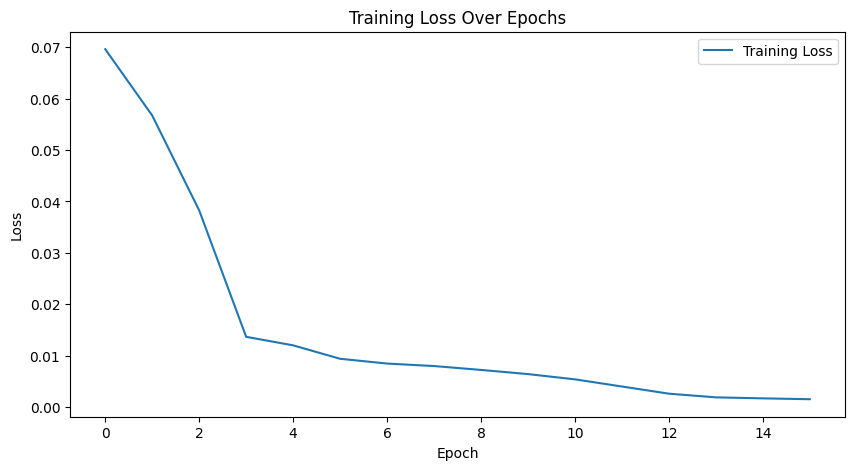

In [65]:
# train
# checkpoint_path = "/best_model.pth"
loss = train_model(model, data_loader, num_epochs, lr, checkpoint_path)
plot_loss(loss)

## **Extract Feature from CNN**

In [66]:
# Get best model
# best_model = model.load_state_dict(torch.load(checkpoint_path))
best_model = model

In [67]:
# Extract Features for Clustering
features_list = []
best_model.eval()
with torch.no_grad():
    for images in data_loader:
        images = images.to(device)
        _, features = best_model(images)
        features_list.append(features.cpu())

# Convert to NumPy for Clustering
features_np = np.concatenate([f.numpy() for f in features_list], axis=0)
print(f"number of features: {len(features_list)}")

number of features: 8


## **Clustering**

In [68]:
from sklearn.cluster import KMeans

# Flatten feature maps for clustering
features_reshaped = features_np.reshape(features_np.shape[0], -1)

# Perform Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_reshaped)

# Print Cluster Assignments
# print(labels)

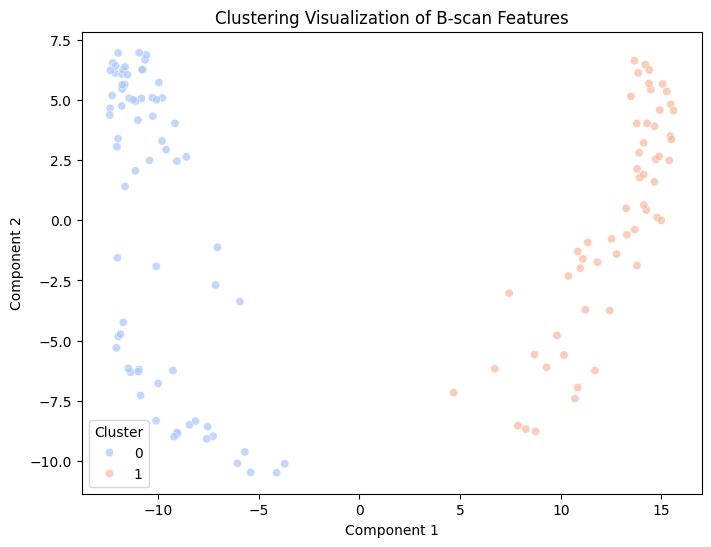

In [69]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)  # Try with PCA first
features_2d = pca.fit_transform(features_reshaped)

# Alternative: t-SNE (may give better clustering visualization)
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# features_2d = tsne.fit_transform(features_reshaped)

# Scatter plot of clustered data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette='coolwarm', alpha=0.7)
plt.title("Clustering Visualization of B-scan Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster")
plt.show()

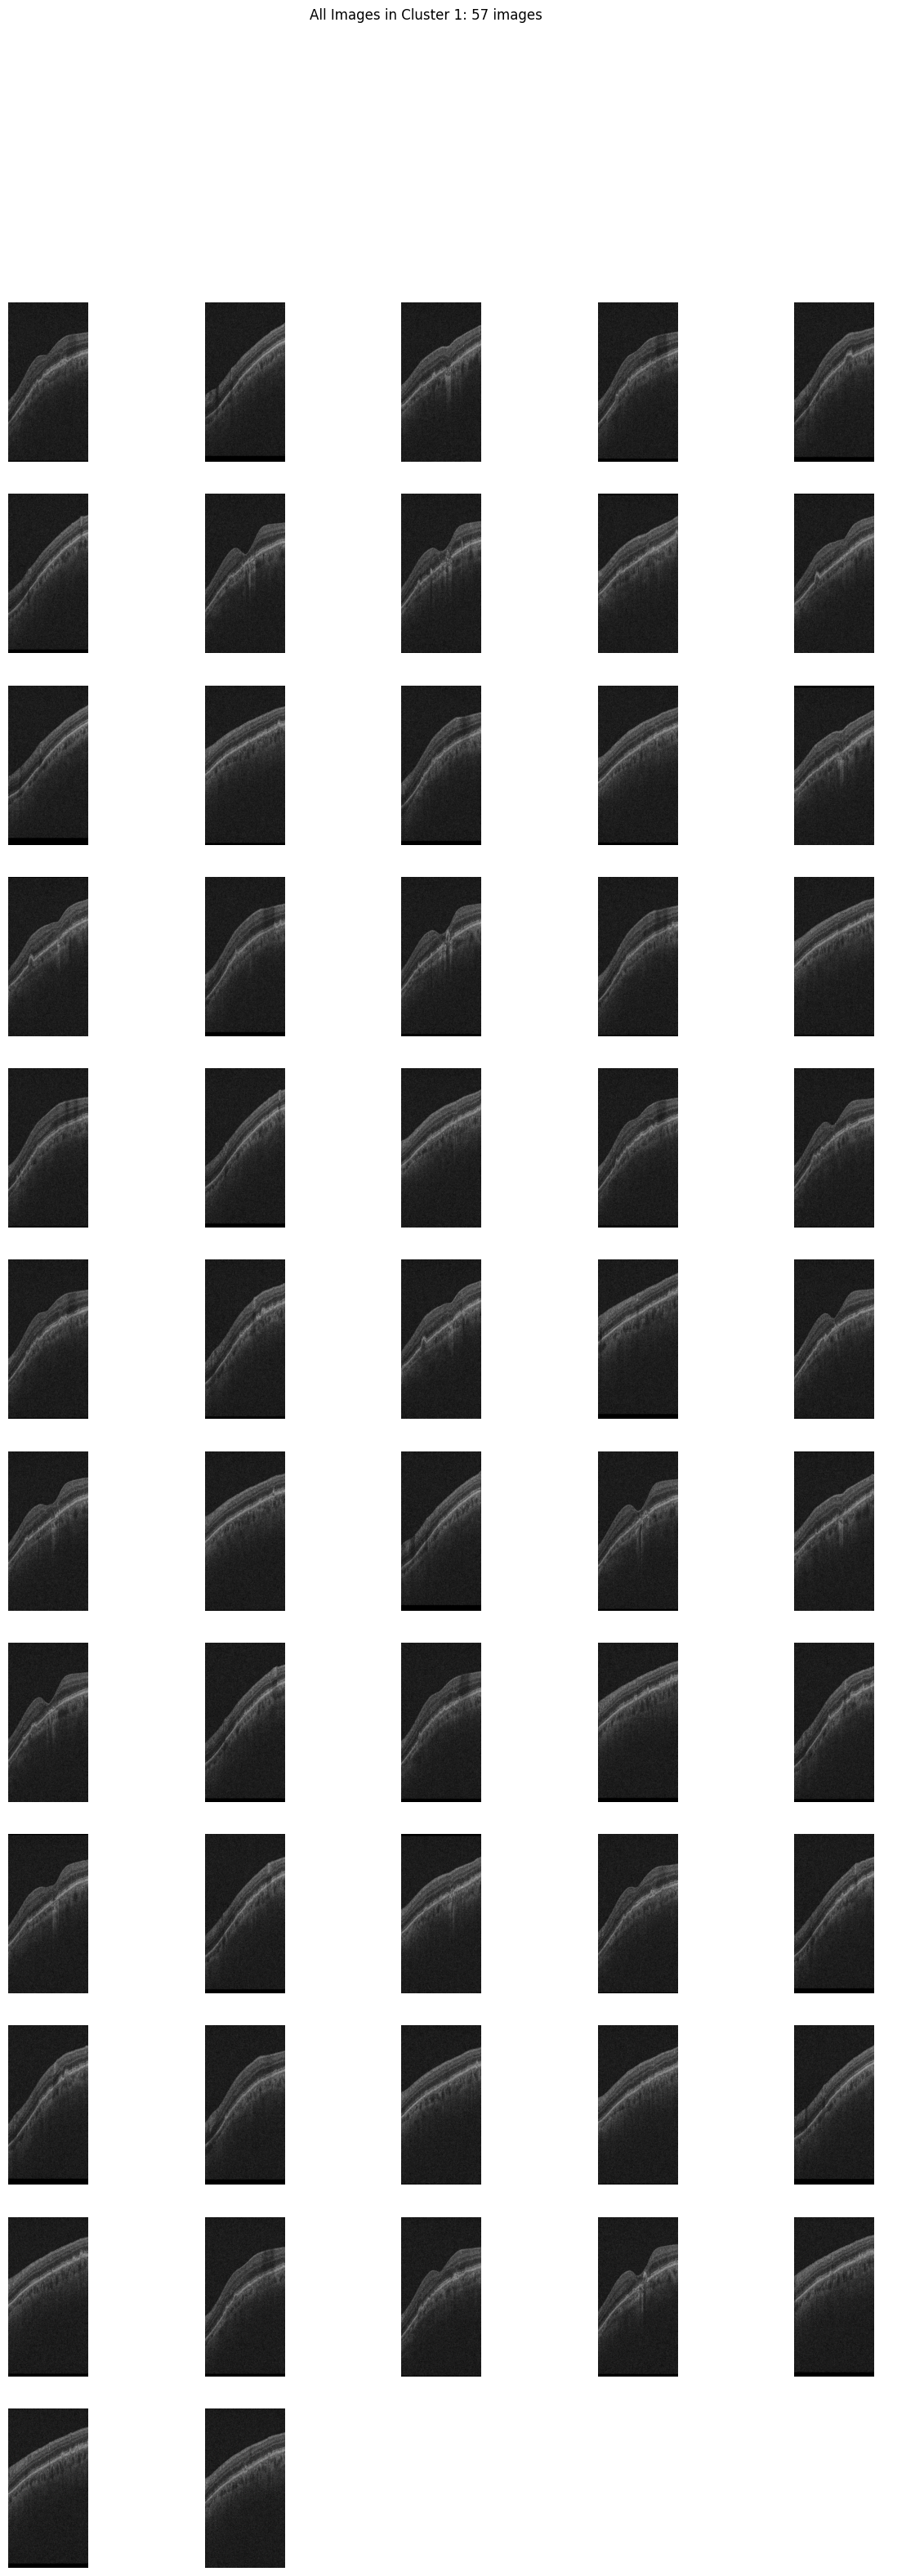

In [70]:
# Select random images from each cluster
# def plot_cluster_examples(dataset, labels, cluster_id, num_images=5):
#     image_paths = dataset.get_image_paths()  # Get image paths
#     indices = [i for i, label in enumerate(labels) if label == cluster_id]
#     selected_indices = random.sample(indices, min(num_images, len(indices)))

#     fig, axes = plt.subplots(1, len(selected_indices), figsize=(15, 5))
#     for i, idx in enumerate(selected_indices):
#         img_path = image_paths[idx]
#         img = Image.open(img_path).convert("RGB")

#         axes[i].imshow(img)
#         axes[i].axis("off")
#     label = "have fovea" if cluster_id else "not have fovea"
#     plt.suptitle(f"Cluster {label} Examples")
#     plt.show()

# Show all images from selected cluster
def plot_cluster_examples(dataset, labels, cluster_id=1):
    """
    Plots all images belonging to a specific cluster.

    Args:
        dataset (CustomDataset): The dataset containing images.
        labels (list or array): Cluster labels for each image.
        cluster_id (int): The cluster ID to display.
    """
    image_paths = dataset.get_image_paths()  # Get all image paths
    indices = [i for i, label in enumerate(labels) if label == cluster_id]

    if not indices:
        print(f"No images found for cluster {cluster_id}.")
        return

    num_images = len(indices)
    cols = min(num_images, 5)  # Limit to 5 images per row
    rows = (num_images + cols - 1) // cols  # Compute required rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        axes[i].imshow(img)
        axes[i].axis("off")

    # Hide any extra subplots (if images are fewer than grid size)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"All Images in Cluster {cluster_id}: {num_images} images")
    plt.show()


# Plot examples from both clusters
# plot_cluster_examples(dataset, labels, cluster_id=0)
plot_cluster_examples(dataset, labels, cluster_id=1)

## **Locate Fovea**

In [ ]:
def gaussian_kernel_2d(size=3, sigma=1.0):
    """Creates a 2D Gaussian kernel."""
    x = torch.arange(size) - size // 2
    y = torch.arange(size) - size // 2
    x, y = torch.meshgrid(x, y, indexing='ij')

    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()

    return kernel


def apply_gaussian_smoothing_2d(output, kernel_size=3, sigma=1.0):
    """Applies 2D Gaussian smoothing to each depth slice of a 3D network output."""
    kernel = gaussian_kernel_2d(kernel_size, sigma).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

    smoothed_slices = []
    for d in range(output.shape[0]):  # Loop over depth
        slice_2d = output[d].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
        smoothed_slice = F.conv2d(slice_2d, kernel, padding=kernel_size // 2).squeeze(0).squeeze(0)
        smoothed_slices.append(smoothed_slice)

    return torch.stack(smoothed_slices)  # Shape: (D, H, W)

def fill_max_probability_color(smoothed_output):
    """Finds the max probability location and highlights it on a 2D grayscale image."""
    # Convert 3D (D, H, W) tensor to 2D by taking max along depth
    max_projection, max_depth = torch.max(smoothed_output, dim=0)  # Shape: (H, W)

    # Get max probability location
    max_idx = torch.argmax(max_projection)
    max_y, max_x = np.unravel_index(max_idx.cpu().numpy(), max_projection.shape)

    # Normalize grayscale image to 255 range
    gray_image = (max_projection.cpu().numpy() * 255).astype(np.uint8)

    # Convert grayscale to PIL image
    img = Image.fromarray(gray_image, mode='L')  # 'L' for grayscale

    # Highlight the max probability pixel with red
    img_colored = img.convert("RGB")  # Convert grayscale to RGB
    pixels = img_colored.load()
    pixels[max_x, max_y] = (255, 0, 0)  # Set max prob pixel to red

    return img_colored, (max_x, max_y, max_depth[max_y, max_x].item())

def process_output(output, kernel_size=3, sigma=1.0):
    """Applies 2D Gaussian smoothing and marks the highest probability pixel."""
    smoothed_output = apply_gaussian_smoothing_2d(output, kernel_size, sigma)
    color_image, max_pos = fill_max_probability_color(smoothed_output)

    return color_image, max_pos

def show_image(image):
    """Displays an image using PIL."""
    image.show()

In [ ]:
# Example usage
output = torch.rand(5, 5, 5)  # Example grayscale output tensor
color_img, max_position = process_output(output, kernel_size=1, sigma=1.0)

print("Max Probability Position:", max_position)
show_image(color_img)  # Show the result using PIL

Max Probability Position: (2, 4, 0)
